# Poisson equation in 1D with hard boundary conditions

## Problem setup

We will solve a Poisson equation:
$$
-\nabla^2 u = 8\sin(8x) + \sum_{i=1}^{4} i \sin(ix), \qquad x \in [0, \pi]
$$
with the Dirichlet boundary conditions
$$
u(x=0) = 0, \quad u(x=\pi) = \pi
$$

The exact solution is $u(x) = x + \frac{\sin(8x)}{8} + \sum_{i=1}^{4} \frac{\sin(ix)}{i}$.

## Implementation

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'tensorflow'

In [ ]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np
import matplotlib.pyplot as plt

2023-10-09 09:47:17.473705: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-09 09:47:17.473749: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-09 09:47:17.473779: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-09 09:47:17.483214: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends

Enable just-in-time compilation with XLA.



In [ ]:
geom = dde.geometry.Interval(0, np.pi)

In [ ]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    summation = sum([i*tf.sin(i*x) for i in range(1, 5)])
    return -dy_xx - 8*tf.sin(8*x) - summation

In [ ]:
def true_solution(x):
    summation = sum([np.sin(i*x)/i for i in range(1, 5)])
    return x + np.sin(8*x)/8 + summation

In [ ]:
data = dde.data.PDE(geom,
                    pde,
                    [],
                    num_domain=64,
                    solution=true_solution,
                    num_test=400)

In [ ]:
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

2023-10-09 09:47:21.654433: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-09 09:47:21.655296: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10520 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:82:00.0, compute capability: 7.0


We define the transformation of the output and apply it to the network.

In [ ]:
def output_transform(x, y):
    return x*(np.pi-x)*y + x

In [ ]:
net.apply_output_transform(output_transform)

In [ ]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-4, decay=("inverse time", 1000, 0.3), metrics=["l2 relative error"])

Compiling model...
'compile' took 0.016515 s



In [ ]:
loss_history, train_state = model.train(iterations=30000)

Training model...



/userhome/jeon_mg/miniforge3/envs/pinn_tf/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2023-10-09 09:47:23.253384: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5562b2716f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-09 09:47:23.253434: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2023-10-09 09:47:23.267213: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-09 09:47:23.910229: I tensorflow/compiler

Step      Train loss    Test loss     Test metric   
0         [5.10e+01]    [5.10e+01]    [2.86e-01]    
1000      [3.04e+01]    [3.03e+01]    [9.69e-02]    
2000      [1.28e+01]    [1.31e+01]    [3.15e-02]    
3000      [1.01e+01]    [1.03e+01]    [3.33e-02]    
4000      [3.76e+00]    [4.40e+00]    [1.54e-02]    
5000      [1.68e-01]    [2.90e-01]    [7.81e-03]    
6000      [1.89e-02]    [4.15e-02]    [2.23e-03]    
7000      [5.70e-03]    [1.39e-02]    [7.81e-04]    
8000      [2.12e-03]    [5.70e-03]    [3.70e-04]    
9000      [1.04e-03]    [2.86e-03]    [1.81e-04]    
10000     [6.26e-04]    [1.66e-03]    [9.46e-05]    
11000     [4.14e-04]    [1.06e-03]    [4.64e-05]    
12000     [2.61e-04]    [7.12e-04]    [4.05e-05]    
13000     [1.74e-04]    [4.92e-04]    [2.62e-05]    
14000     [1.24e-04]    [3.57e-04]    [1.72e-05]    
15000     [9.17e-05]    [2.67e-04]    [1.45e-05]    
16000     [7.15e-05]    [2.10e-04]    [2.94e-05]    
17000     [5.48e-05]    [1.61e-04]    [1.17e-0

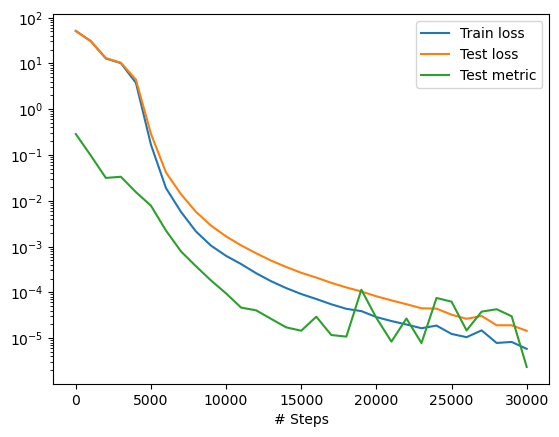

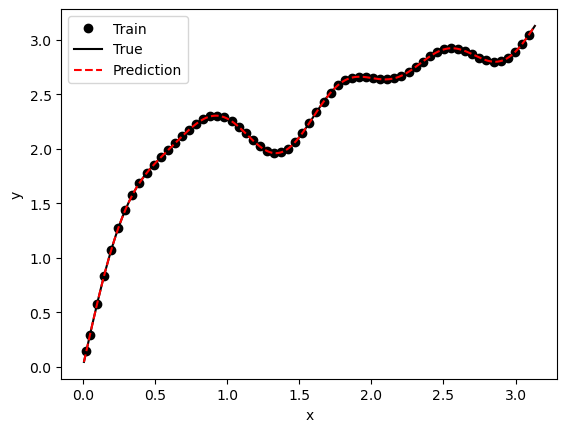

In [ ]:
dde.saveplot(loss_history, train_state, issave=False, isplot=True)